In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
should_skip = False

In [3]:
#@title Install libraries
if not should_skip:
  !pip install -U -qq git+https://github.com/huggingface/diffusers.git
  !pip install -qq accelerate transformers ftfy
  !pip install -q gpustat gdown
  !pip install -q pytorch_lightning
  !pip install -q supervision roboflow

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [4]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TVF
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
import sys

# https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unet_2d_condition.py#L175-L182
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from pytorch_lightning import seed_everything

import supervision as sv
from roboflow import Roboflow

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [5]:
if not should_skip:
    #@markdown Add here the URLs to the images of the concept you are adding. 3-5 should be fine
    train_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/2.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/3.jpeg",
    ]
    test_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/5.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/6.jpeg",
        ## You can add additional images here
    ]
#@title Download
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

if not should_skip:
    for save_path,urls in [("./my_concept",train_urls),("./my_concept_test",test_urls)]:
      images = list(filter(None,[download_image(url) for url in urls]))
      if not os.path.exists(save_path):
        os.mkdir(save_path)
      [image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]


if not should_skip:
    !gdown --id 1I8RMKQhPXntlRKorVNZ6yyNpfaOp8wNv
    mask_path="./my_concept_gt"
    !mkdir $mask_path/

    with open("my_concept_gt.zip","r") as f:
        pass
    !unzip -o my_concept_gt.zip

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1I8RMKQhPXntlRKorVNZ6yyNpfaOp8wNv
To: /root/slime-experiments/my_concept_gt.zip
100%|██████████████████████████████████████| 14.7k/14.7k [00:00<00:00, 23.6MB/s]
mkdir: cannot create directory ‘./my_concept_gt/’: File exists
Archive:  my_concept_gt.zip
  inflating: my_concept_gt/1.png     
  inflating: my_concept_gt/0.png     


In [6]:
# %cd /content/
# sys.path.append("/content/slime-experiments/")

In [7]:
# !rm -rf slime-experiments/
# !git clone https://github.com/andrew-healey/slime-experiments
# !cd slime-experiments && git rev-parse --short HEAD

In [8]:
from slime.slime import SLiME
from slime.data.single_class import BinarySegmentationDataset,SegmentationDataModule
from slime.data.rf_coco import SemanticSegmentationDataset

In [9]:
# Set the seed
seed_everything(42)

Seed set to 42


42

In [10]:
#@title Download Roboflow dataset
rf = Roboflow(api_key="PPa4WEink4MOydk4Rbzb")
project = rf.workspace("andrew-healey-qy1qe").project("dogs-yvwts")
dataset = project.version(1).download("coco-segmentation")

rf_train_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
    force_masks=True
)
rf_train_dataset.classes[0] = "null"

rf_test_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
    force_masks=True
)
rf_test_dataset.classes[0] = "null"

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Dogs-1 in coco-segmentation:: 100%|██████████| 11/11 [00:00<00:00, 4467.21it/s]


In [12]:
train_dataset = BinarySegmentationDataset(
    data_root="my_concept",
    mask_root="my_concept_gt",
)
test_dataset = BinarySegmentationDataset(
    data_root="my_concept_test",
    mask_root=None
)

data_module = SegmentationDataModule(
    train_dataset,
    test_dataset,
    iters_per_epoch=100,
    batch_size=1,
)

In [13]:
slime = SLiME(
    use_self_attn=True,
).cuda()

It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.


In [14]:
from pytorch_lightning import Trainer

trainer = Trainer(
    default_root_dir="run",
    limit_train_batches=1.0,
    num_sanity_val_steps=0,
    max_epochs=1,
    enable_checkpointing=False,
)

trainer.fit(slime, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type            | Params
-----------------------------------------------------------
0 | sd                     | StableDiffusion | 900 M 
1 | cross_layer_multiplier | Multiplier      | 32    
2 | self_layer_multiplier  | Multiplier      | 32    
3 | cross_map_multiplier   | Multiplier      | 4     
4 | pred_map_

Training: |          | 0/? [00:00<?, ?it/s]

pred 0.08 0.08 ce loss 0.7 mse loss 0.34
pred -0.97 0.05 ce loss 0.59 mse loss 1.77
pred -1.62 0.04 ce loss 0.82 mse loss 4.29
pred -1.3 0.03 ce loss 0.6 mse loss 2.7
pred -0.9 0.03 ce loss 0.69 mse loss 1.92
pred -0.39 0.03 ce loss 0.63 mse loss 0.65
pred -0.2 0.03 ce loss 0.65 mse loss 0.43
pred -0.29 0.03 ce loss 0.67 mse loss 0.7
pred -0.42 0.02 ce loss 0.62 mse loss 0.69
pred -0.68 0.02 ce loss 0.68 mse loss 1.39
pred -0.84 0.02 ce loss 0.69 mse loss 1.75
pred -0.86 0.02 ce loss 0.59 mse loss 1.5
pred -0.9 0.02 ce loss 0.59 mse loss 1.6
pred -0.95 0.02 ce loss 0.7 mse loss 2.04
pred -0.86 0.02 ce loss 0.69 mse loss 1.8
pred -0.66 0.02 ce loss 0.6 mse loss 1.09
pred -0.56 0.02 ce loss 0.67 mse loss 1.15
pred -0.43 0.02 ce loss 0.62 mse loss 0.71
pred -0.45 0.02 ce loss 0.62 mse loss 0.74
pred -0.59 0.02 ce loss 0.67 mse loss 1.2
pred -0.67 0.02 ce loss 0.6 mse loss 1.11
pred -0.82 0.02 ce loss 0.69 mse loss 1.69
pred -0.84 0.02 ce loss 0.69 mse loss 1.76
pred -0.77 0.02 ce loss 0.6

`Trainer.fit` stopped: `max_epochs=1` reached.


In [15]:
slime.cuda(); 0

0

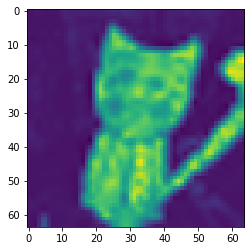

In [16]:
import matplotlib.pyplot as plt
plt.imshow(slime.latest_preds[-1].swapaxes(1,2).reshape((-1,slime.text_tokens,64,64))[0,1])

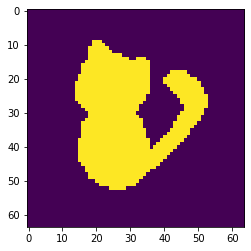

In [104]:
#@title Infer on test set
out_mask = None
loader = data_module.test_dataloader()
for i,batch in enumerate(loader):
  out_mask = slime.predict_step(batch,i).cpu().numpy()
  break

import matplotlib.pyplot as plt
for i in range(len(out_mask)):
  plt.imshow(out_mask[i].reshape((64,64)))
  plt.show()

# Experiments with spectral analysis

i.e. use attn map, or transposed attn map, or symmetrized map?
(unchecked) maybe use cosine similarity of embeds


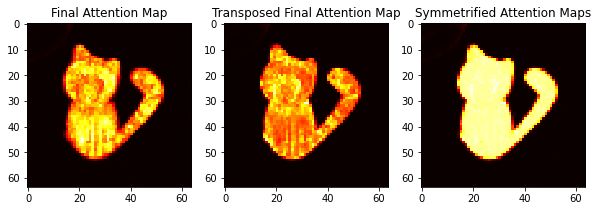

In [96]:
# visualize self-attn maps

self_attn_maps = slime.latest_selfs

# pick a random token to visualize

batch_num = 0
layer_num = 0

mask = out_mask[batch_num].astype(bool)==1

layer = self_attn_maps[layer_num]
num_tokens = layer.shape[1]
token_num = random.randint(0, num_tokens - 1)

im_dims = int(math.sqrt(layer.shape[-1]))

raw_map = layer[batch_num]

# make attn map cols sum to 1
attn_map = raw_map / raw_map.sum(axis=1)
attn_map_t = raw_map.T / raw_map.sum(axis=0)
attn_map_sym = (attn_map + attn_map_t) / 2

final_attn_map = attn_map[mask].mean(axis=0).reshape(im_dims, im_dims).copy()
final_attn_t_map = attn_map_t[mask].mean(axis=0).reshape(im_dims, im_dims).copy()
final_attn_sym_map = attn_map_sym[mask].mean(axis=0).reshape(im_dims, im_dims).copy()

plt.figure(figsize=(10, 5))

# Plotting the final attention map
plt.subplot(1, 3, 1)
plt.imshow(final_attn_map, cmap='hot', interpolation='nearest')
plt.title('Final Attention Map')

# Plotting the transposed final attention map
plt.subplot(1, 3, 2)
plt.imshow(final_attn_t_map, cmap='hot', interpolation='nearest')
plt.title('Transposed Final Attention Map')

# Plotting the average of the two
plt.subplot(1, 3, 3)
plt.imshow(final_attn_sym_map, cmap='hot', interpolation='nearest')
plt.title('Symmetrified Attention Maps')


# plt.colorbar()

plt.show()


In [97]:
chosen_attn_map = attn_map

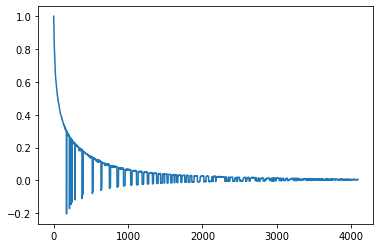

In [98]:
eigenvals, eigenvectors = np.linalg.eig(chosen_attn_map)
plt.plot(eigenvals.real)

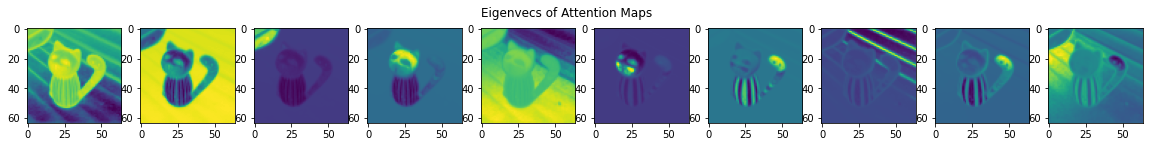

In [99]:
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
plt.suptitle('Eigenvecs of Attention Maps')
for i in range(10):
    eigenvec = eigenvectors[:,i].real.reshape(im_dims, im_dims)
    axs[i].imshow(eigenvec)
plt.show()


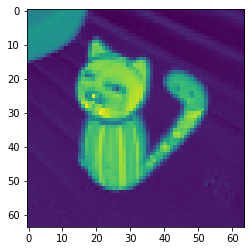

In [100]:
#@title Normalized cut
# see https://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf
A = torch.from_numpy(chosen_attn_map)
B = torch.diag(torch.sum(A, dim=1))

num_eigenvectors = 10

gen_eigenvals, gen_eigenvectors = torch.lobpcg((B-A).cuda(), B=B.cuda(),k=num_eigenvectors,largest=False)
second_eigenvector = gen_eigenvectors[:,1].real.cpu()
plt.imshow(second_eigenvector.numpy().reshape(im_dims, im_dims))

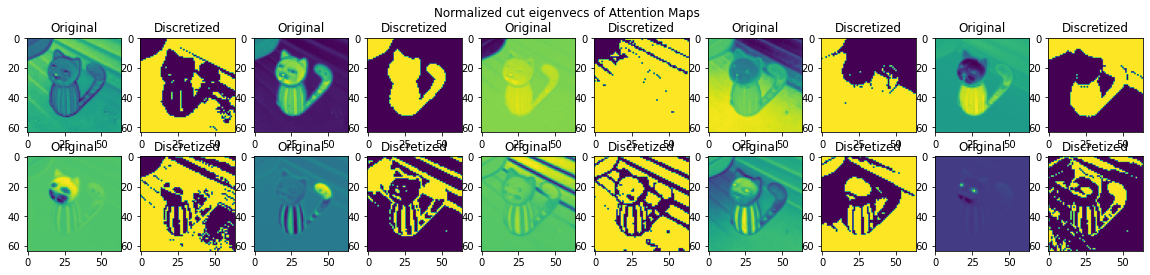

In [101]:
fig, axs = plt.subplots(2, num_eigenvectors, figsize=(20, 4))
plt.suptitle('Normalized cut eigenvecs of Attention Maps')
for i in range(num_eigenvectors):
    gen_eigenvec = gen_eigenvectors[:,i].real.reshape(im_dims, im_dims).cpu()
    # Plot the original eigenvector
    axs[i//5, 2*(i%5)].imshow(gen_eigenvec)
    axs[i//5, 2*(i%5)].set_title('Original')
    # Discretize the eigenvector
    disc_gen_eigenvec = (gen_eigenvec > gen_eigenvec.mean()).float()
    # Plot the discretized eigenvector
    axs[i//5, 2*(i%5)+1].imshow(disc_gen_eigenvec)
    axs[i//5, 2*(i%5)+1].set_title('Discretized')
plt.show()


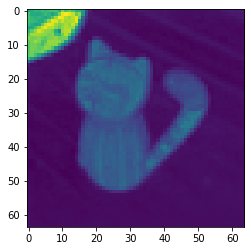

In [103]:
from scipy.linalg import eigh
# Provided utility function by the user
def second_smallest_eigenvector(A, D):
    # get the second smallest eigenvector from affinity matrix
    _, eigenvectors = eigh(D-A, D, subset_by_index=[1,2])
    eigenvec = np.copy(eigenvectors[:, 0])
    second_smallest_vec = eigenvectors[:, 0]
    return eigenvec, second_smallest_vec


util_eigenvec, second_smallest_vec = second_smallest_eigenvector(chosen_attn_map, np.diag(chosen_attn_map.sum(axis=1)))
plt.imshow(1-util_eigenvec.reshape(im_dims, im_dims))